In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from toolbox.utils.plotting import draw_ellipse
import lsst.afw.geom
from matplotlib.patches import Ellipse
from hscana import MyCat
from candy.params import params
shape_model = 'shape.hsm.moments'

In [2]:
def calc_principal_axes(Mxx, Mxy, Myy):
    """
    Convert moments into principal axes and angle.
    """
    Muu_p_Mvv = Mxx + Myy
    Muu_m_Mvv = np.sqrt((Mxx - Myy)**2 + 4*Mxy**2)
    Muu = 0.5*(Muu_p_Mvv + Muu_m_Mvv)
    Mvv = 0.5*(Muu_p_Mvv - Muu_m_Mvv)
    theta = 0.5*np.arctan2(2*Mxy, Mxx - Myy)
    a = np.sqrt(Muu)
    b = np.sqrt(Mvv)
    return a, b, theta*180.0/np.pi

In [3]:
def draw(candy_num, scale=1.0, image_size=8.0):
    tract, patch, parent = params[candy_num]
    mycat = MyCat(tract=tract, patch=patch, usewcs=True)
    mycat.apply_cuts(mycat.cat.get('parent')==parent)
    children = mycat.cat

    moments = []
    separable = []
    axes = []

    for i, child in enumerate(children):
        affine = mycat.wcs.linearizePixelToSky(child.get('coord'), lsst.afw.geom.degrees)
        shape = child.get(shape_model)
        moments.append(shape.transform(affine.getLinear()))
        separable.append(lsst.afw.geom.ellipses.SeparableDistortionDeterminantRadius(moments[i]))
        axes.append(lsst.afw.geom.ellipses.Axes(moments[i]))

    f1, a1 = plt.subplots()
    center = np.array([0.0, 0.0])
    ixx_sum = 0.0
    ixy_sum = 0.0
    iyy_sum = 0.0
    aa = 0.0
    bb = 0.0
    theta = []
    for child, mom, axis in zip(children, moments, axes):
        ra, dec = child.get('coord.ra').asDegrees(), child.get('coord.dec').asDegrees()
        mu = np.array([ra, dec])
        center += mu
        a1.plot(ra, dec, 'bo')
        if not np.isnan(axis.getA()):
            aa += axis.getA()**2
            bb += axis.getB()**2
            theta.append(axis.getTheta())
        ixx, iyy, ixy = mom.getIxx(), mom.getIyy(), mom.getIxy()
        if not np.isnan(ixx):
            ixx_sum += ixx
            ixy_sum += ixy
            iyy_sum += iyy
        C = np.array([[ixx, ixy], [ixy, iyy]])
        draw_ellipse(mu, C, scales=[scale], ax=a1, ec='k', fc='none')
    center /= len(children)
    theta = np.median(theta)
    A, B, Theta = calc_principal_axes(ixx_sum, ixy_sum, iyy_sum)
    a1.plot(center[0], center[1], 'm*', ms=15)
    a1.add_patch(Ellipse(center, 2*scale*A, 2*scale*B, Theta, ec='r', fc='none'))
    a1.add_patch(Ellipse(center, 2*scale*np.sqrt(aa), 2*scale*np.sqrt(bb), theta*180.0/np.pi, ec='g', fc='none'))
    side = image_size/3600.0
    a1.set_xlim(center[0]-side, center[0]+side)
    a1.set_ylim(center[1]-0.8*side, center[1]+0.8*side)
    a1.invert_xaxis()
    return np.sqrt(aa), np.sqrt(bb), A, B

4.24716573672 1.87898359636 3.3602678096 3.20586905508
3.96957084024 1.9027503447 3.63620694802 2.48111881238
3.58188178061 2.35528825383 3.20408069795 2.8480039905
1.65758717174 0.868300432923 1.631853088 0.915749077495
4.3543123421 2.44049648124 3.62244860567 3.43422846456
6.23188005917 3.65899384441 5.36507493647 4.84154272431


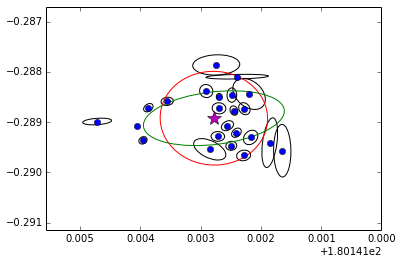

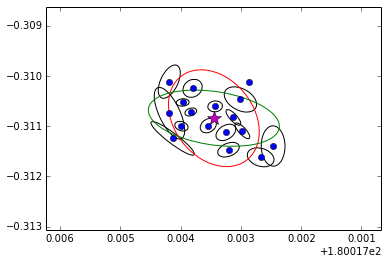

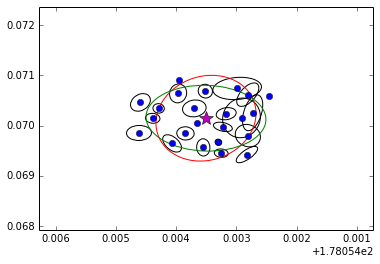

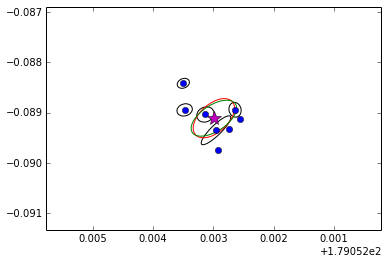

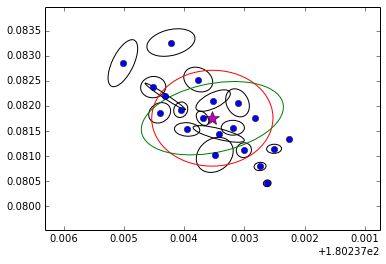

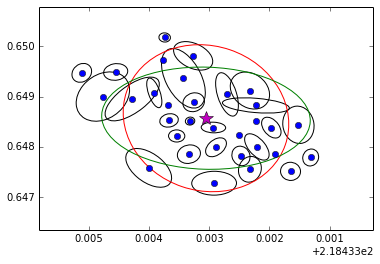

In [4]:
for i in range(6):
    a, b, A, B = draw(i+1, image_size=10.0)
    print a*3600, b*3600, A*3600, B*3600